# Описание проекта

Подготовить прототип модели машинного обучения для золотодобывающей компании. Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обратимся к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**Технологический процесс**

Как золото получают из руды?

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

        1. Флотация
        
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

        2. Очистка
        
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Наименование признаков**

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

    Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
rougher — флотация

    primary_cleaner — первичная очистка
    secondary_cleaner — вторичная очистка
    final — финальные характеристики

Возможные значения для блока [тип_параметра]:

    input — параметры сырья
    output — параметры продукта
    state — параметры, характеризующие текущее состояние этапа
    calculation — расчётные характеристики

**Метрика качества**

Для решения задачи используем метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import stats as st
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

            Загрузили библиотеки и инструменты, которые могут нам понадобиться.
            
            Далее - загрузим наши данные и посмотрим на них.

In [2]:
df_train = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\gold\gold_recovery_train.csv')
df_test = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\gold\gold_recovery_test.csv')
df_full = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\gold\gold_recovery_full.csv')

In [3]:
#df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
#df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
#df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

            Данные обещают быть большими, поэтому поставим отображение всех признаков и объектов.

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


Есть пропуски

посмотрим в процентах. Пропуски меньше 10% - можно смело удалять. Но проблема в том, что тут пропуски в разных столбцах и могут не перекрываться, то есть в одном столбце 6% пропусков и в другом - 8%, но если удалить пропуски - выйдет, что удалено 14% ((

Мы проверим это....

In [6]:
s = df_train.isna().sum()
s = s.sort_values(ascending=False)*100/len(df_train)
s

rougher.output.recovery                               15.260973
rougher.output.tail_ag                                13.345196
rougher.output.tail_sol                               13.339265
rougher.output.tail_au                                13.339265
secondary_cleaner.output.tail_sol                     11.779359
rougher.input.floatbank11_xanthate                    11.293001
final.output.recovery                                  9.021352
primary_cleaner.input.sulfate                          7.752076
primary_cleaner.input.depressant                       7.485172
rougher.calculation.au_pb_ratio                        7.366548
rougher.input.floatbank10_sulfate                      6.192171
primary_cleaner.input.xanthate                         5.842230
primary_cleaner.output.concentrate_sol                 3.772242
rougher.input.floatbank11_sulfate                      3.695136
rougher.state.floatbank10_e_air                        3.576512
rougher.input.feed_rate                 

            Попотеем на этапе предобработки, пытаясь их заполнить

Видим, что у нас столбец содержащий сведения о дате и времени совсем не в том типе данных находится. Т.к. это устраняется просто, давайте сразу же и преобразуем.

In [7]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')

In [8]:
df_train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Посмотрели бегло на тренировочную выборку.

В ней есть пропуски до 15% в разных признаках.

Сразу преобразовали тип данных в полноценную дату.

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [10]:
s = df_test.isna().sum()
s = s.sort_values(ascending=False)*100/len(df_test)
s

rougher.input.floatbank11_xanthate            6.028005
primary_cleaner.input.sulfate                 5.157104
primary_cleaner.input.depressant              4.849727
rougher.input.floatbank10_sulfate             4.388661
primary_cleaner.input.xanthate                2.834699
rougher.input.floatbank10_xanthate            2.100410
rougher.input.feed_sol                        1.144126
rougher.input.floatbank11_sulfate             0.939208
rougher.input.feed_rate                       0.683060
secondary_cleaner.state.floatbank3_a_air      0.580601
secondary_cleaner.state.floatbank2_b_air      0.392760
rougher.input.feed_size                       0.375683
secondary_cleaner.state.floatbank2_a_air      0.341530
rougher.state.floatbank10_e_air               0.290301
rougher.state.floatbank10_d_air               0.290301
rougher.state.floatbank10_a_air               0.290301
rougher.state.floatbank10_b_air               0.290301
rougher.state.floatbank10_c_air               0.290301
rougher.st

In [11]:
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')

In [12]:
df_test.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

В тестовой выборке содержание пропусков до 6% в разных признаках.

Также преобразовали дату, легко и быстро.

Заметили, что в тестовой выборке меньше признаков, чем в тренировочной. Это связано с тем, что некоторые данные у нас появляются уже после момента, когда нам нужен прогноз модели. Также нет в ней целевых признаков, в последующих шагах понадобится их достать из полного датасета.

In [13]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [14]:
s = df_full.isna().sum()
s = s.sort_values(ascending=False)*100/len(df_full)
s

rougher.output.recovery                               13.730410
rougher.output.tail_ag                                12.048776
rougher.output.tail_sol                               12.044374
rougher.output.tail_au                                12.044374
rougher.input.floatbank11_xanthate                     9.935728
secondary_cleaner.output.tail_sol                      9.750836
final.output.recovery                                  8.641486
rougher.calculation.au_pb_ratio                        7.162353
primary_cleaner.input.sulfate                          7.083113
primary_cleaner.input.depressant                       6.805776
rougher.input.floatbank10_sulfate                      5.727241
primary_cleaner.input.xanthate                         5.066913
primary_cleaner.output.concentrate_sol                 3.512942
rougher.input.floatbank11_sulfate                      2.984680
rougher.state.floatbank10_e_air                        2.729354
rougher.input.feed_rate                 

In [15]:
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')

In [16]:
df_full.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

По аналогии с прдыдущими действиями - изменили формат даты.

Посмотрели на пропуски - в итоговом датасете их до 13%, причем максимум пропусков в одном из целевых признаков - "rougher.output.recovery".

__1.2.__

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между расчётами и значением признака. Напишем выводы.


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16788 non-null  float64       
 2   final.output.concentrate_pb                         16788 non-null  float64       
 3   final.output.concentrate_sol                        16490 non-null  float64       
 4   final.output.concentrate_au                         16789 non-null  float64       
 5   final.output.recovery                               15339 non-null  float64       
 6   final.output.tail_ag                                16794 non-null  float64       
 7   final.output.tail_pb                                16677 non-null  float64       
 8   final.

Чтобы непоправимо не испортить данную информацию - создадим копию, с которой и над которой будем производить манипуляции.

Для df_train - это будет work_train и аналогично для другиx df.

In [18]:
work_train = df_train

            Расчитаем recovery:

In [19]:
work_train['culk_recovery'] = (work_train['rougher.output.concentrate_au'] * (work_train['rougher.input.feed_au'] - work_train['rougher.output.tail_au'])) / (work_train['rougher.input.feed_au'] * (work_train['rougher.output.concentrate_au'] - work_train['rougher.output.tail_au'])) * 100


In [20]:
recovery = work_train[['rougher.output.recovery', 'culk_recovery']]

In [21]:
recovery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rougher.output.recovery  14287 non-null  float64
 1   culk_recovery            14577 non-null  float64
dtypes: float64(2)
memory usage: 263.6 KB


Видим, что при расчёте у нас больше заполненных данных. Однозначно стоит ими заменить пропуски в 'rougher.output.recovery'.

In [22]:
len(work_train.loc[work_train.loc[:,'rougher.output.recovery'] == work_train.loc[:,'culk_recovery']])

6856

In [23]:
recovery.head(3)

,rougher.output.recovery,culk_recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308


In [24]:
len(work_train.loc[work_train.loc[:,'rougher.output.recovery'] != work_train.loc[:,'culk_recovery']])

10004

Количество совпадений меньше количества разных ответов. Стоит заметить, что одинаковые ответы совпадают до шести знаков после запятой. Значит значения в 'rougher.output.recovery' - расчётные, и этот расчёт верен не во всех случаях, именно расчёт, т.к. если бы это были величины, полученные в результате измерения опытным путём, то не было бы совпадений до шести знаков после запятой, а были бы лишь приближены к расчётному значению. Это важно, т.к. позволяет при случае нам заменить "неверные" значения на наш верный расчёт.

         Найдём MAE между нашими расчётами и значением признака 'rougher.output.recovery' 
         (который тоже расчётный, но не нами).
         
         Перед этим удалим пропуски в данных, чтобы расчёт был произведен.

In [25]:
recovery = recovery.dropna()

In [26]:
mae_rec = mean_absolute_error(recovery['rougher.output.recovery'], recovery['culk_recovery'])
mae_rec

9.444891926100695e-15

MAE между нашими расчётами и значением признака 'rougher.output.recovery' равна почти нулю, стремится к нему в любом случае. Поэтому можно смело заменять значения 'rougher.output.recovery' на наши расчётные.

__1.3.__

Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?


In [27]:
col_train = list(df_train.columns)
col_test = list(df_test.columns)

In [28]:
features_to_del = col_train
for i in col_test:
    features_to_del.remove(i)
    

features_to_del - признаки, которые есть в тренировочной выборке и полном датасете, но нет в тестовой, поэтому в последующем их нужно будет удалить из тренировочной выборки.

In [29]:
features_to_del

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [30]:
col_test

['date',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

Ох, нашей будущей модели не позавидуешь....

Нет финальных признаков вовсе, нет результата, точнее - результатОВ флотации и первичной со вторичной очисток. Есть только то, что получаем на вход перед флотацией  и дальнейшие параметры при очистках, по типу подаваемого воздуха, реактивов, их количества и прочее, то есть заданные ещё перед работой системы параметры.

                                            ***

__1.4.__

**Предобработка данных.**

Загляну немного вперед, сказав, что у нас у __одних__ данных в разных датасетах __разные__ индексы, из-за чего могут возникнуть проблемы. НО время и дата у одних данных в разных датасетах - одна, значит можно просто проидексировать дату. Так и сделаем сейчас, в шаге - предобработка данных.

In [31]:
work_train = work_train.set_index(pd.DatetimeIndex(work_train["date"]))

In [32]:
work_test = df_test.set_index(pd.DatetimeIndex(df_test["date"]))

In [33]:
work_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5554 non-null   float64       
 2   primary_cleaner.input.depressant            5572 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5690 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5840 non

In [34]:
work_full = df_full.set_index(pd.DatetimeIndex(df_full["date"]))

In [35]:
work_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float64       
 7   final.output.tail_pb                                22516 n

Мы получили в качестве индекса - дату и время, а также, чтобы не трогать исходные данные, создали копии, с которыми и будем работать.

__1.4.1__

Избавляемся от пропусков в данных.

Т.к. нам известно, что соседние по времени параметры часто похожи, то можно попробовать применить метод интерполяции для вычисления пропущенных значений. 

In [36]:
work_train = work_train.interpolate(method='time')

In [37]:
work_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16860 non-null  float64       
 2   final.output.concentrate_pb                         16860 non-null  float64       
 3   final.output.concentrate_sol                        16860 non-null  float64       
 4   final.output.concentrate_au                         16860 non-null  float64       
 5   final.output.recovery                               16860 non-null  float64       
 6   final.output.tail_ag                                16860 non-null  float64       
 7   final.output.tail_pb                                16860 n

            Что касается пропусков в тестовой выборке, то там максимальное количество пропусков - 6%.
            Можно попробовать удалить и посмотреть сколько процентов удалится.

In [38]:
len(work_test.dropna())*100/len(work_test)

91.92281420765028

            9% - немного, можно было бы удалить, НО, если заглянуть вперед, то в данных - будут аномалии (нулевые и околонулевые значения), 
            которые также нужно будет удалять и тогда от данных ничего не остается ((
            

Заглядывая вперед (то есть возвращаясь назад), нам понадобятся таргетные признаки, которые будет предсказывать модель, их 2:
'rougher.output.recovery' и 'final.output.recovery'.

Проиндексировав df_full, сделав его work_full - дополним наш work_test.

In [39]:
work_test[['rougher.output.recovery', 'final.output.recovery']] = work_full[['rougher.output.recovery', 'final.output.recovery']]

И вернемся к интерполяции.

In [40]:
work_test = work_test.interpolate(method='time')

In [41]:
work_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5856 non-null   float64       
 2   primary_cleaner.input.depressant            5856 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5856 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5856 non

Официально заявляю, что пропусков в данных нет.

# 2. Анализ данных

__2.1.__

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

In [42]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float64       
 7   final.output.tail_pb                                22516 non-null  float64       
 8   final.

Смотреть как меняеются концентрации металлов предлогаю на полном датафрейме, т.к. он максимально информативен. Напомню себе, что я уже создал копию для работы и правок - work_full.

По одному металлу посмотрим на разных стадиях его содержание в сырье

### Aurum 

        Концентрация в получаемом сырье.

In [43]:
aurum = work_full[['rougher.input.feed_au','rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]

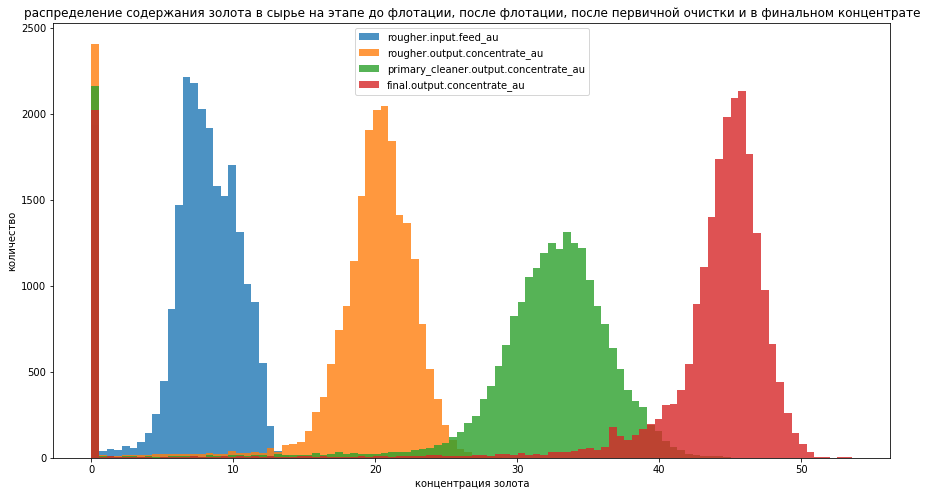

In [44]:
aurum.plot(kind='hist', bins=100, alpha=0.8, figsize=(15,8))
plt.title("распределение содержания золота в сырье на этапе до флотации, после флотации, после первичной очистки и в финальном концентрате"); 
plt.xlabel("концентрация золота")
plt.ylabel("количество")
plt.show()

в 5 раз увеличилась концентрация золота.

            Содержание золота в отвальных хвостах после флотации, после первичной обработки и после вторичной обработки

In [45]:
aurum_tail = work_full[['rougher.output.tail_au','primary_cleaner.output.tail_au','secondary_cleaner.output.tail_au']]

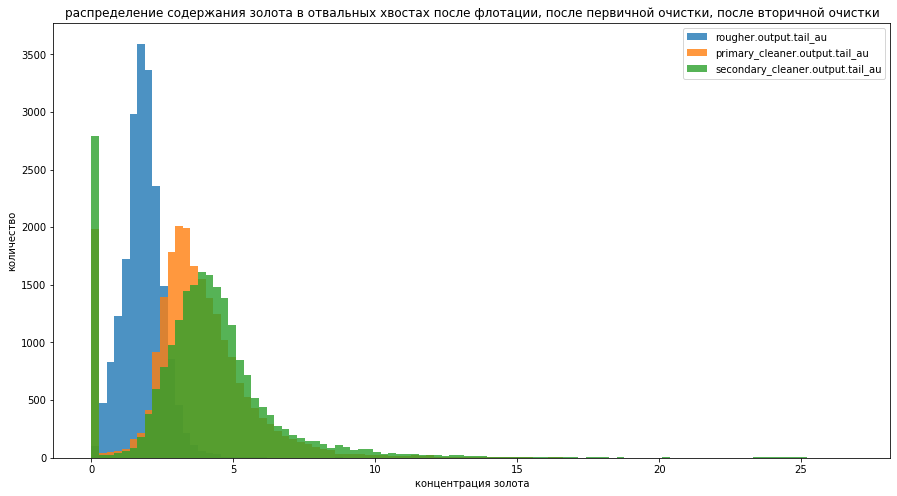

In [46]:
aurum_tail.plot(kind='hist', bins=100, alpha=0.8, figsize=(15,8))
plt.title("распределение содержания золота в отвальных хвостах после флотации, после первичной очистки, после вторичной очистки"); 
plt.xlabel("концентрация золота")
plt.ylabel("количество")
plt.show()

final.output.tail_ХХ - решил не брать в график, т.к. он показывает среднее содержание металлов в общей смеси хвостов и загрязняет график для чтения.

Видим, что максимальная потеря золота идёт на этапе вторичной очистки.

### Argentum

            Концентрация в получаемом сырье.

In [47]:
argentum = work_full[['rougher.input.feed_ag','rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]

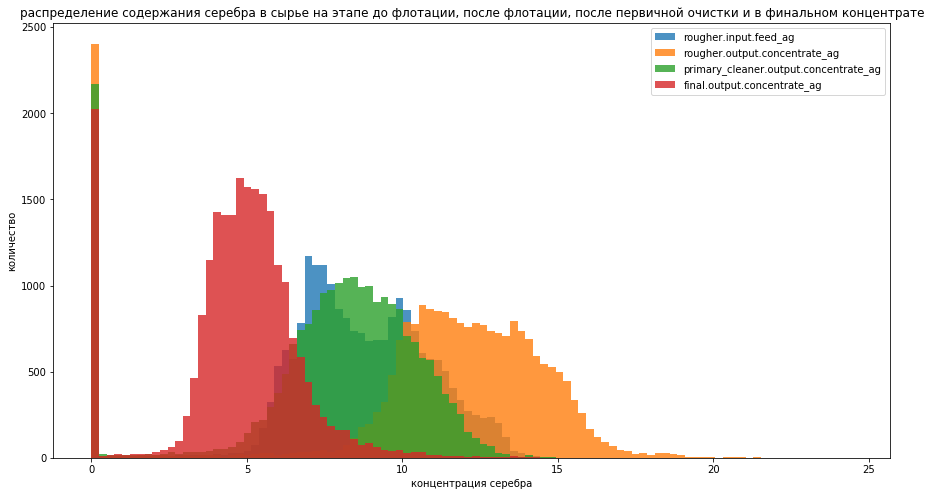

In [48]:
argentum.plot(kind='hist', bins=100, alpha=0.8, figsize=(15,8))
plt.title("распределение содержания серебра в сырье на этапе до флотации, после флотации, после первичной очистки и в финальном концентрате"); 
plt.xlabel("концентрация серебра")
plt.ylabel("количество")
plt.show()

Во время первичной и вторичной обработки сырья идёт большая потеря серебра, в результате в финальном концентрате его менее, чем до флотации в 2 раза. Можно предположить, что в отвальных хвостах серебра будет больше, чем в финальном концентрате.

                Содержание серебра в отвальных хвостах после флотации, после первичной обработки и после вторичной обработки

In [49]:
argentum_tail = work_full[['rougher.output.tail_ag','primary_cleaner.output.tail_ag','secondary_cleaner.output.tail_ag', 'final.output.tail_ag']]

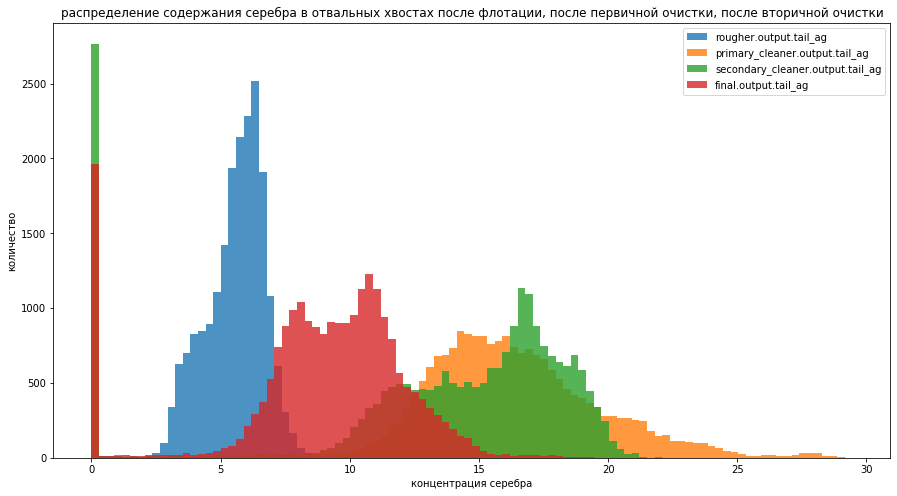

In [50]:
argentum_tail.plot(kind='hist', bins=100, alpha=0.8, figsize=(15,8))
plt.title("распределение содержания серебра в отвальных хвостах после флотации, после первичной очистки, после вторичной очистки"); 
plt.xlabel("концентрация серебра")
plt.ylabel("количество")
plt.show()

Серебра в final.tail_ag больше, чем в финальном концентрате. Смело можно отправлять на очистку и выделение серебра, если таковая окупится, но лучше отдельно сохранить отвальные хвосты после первичной и вторичной очистки, исключив хвост после флотации и попробовать выделить серебро из них.

### Plumbum

            Концентрация в получаемом сырье.

In [51]:
plumbum = work_full[['rougher.input.feed_pb','rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]

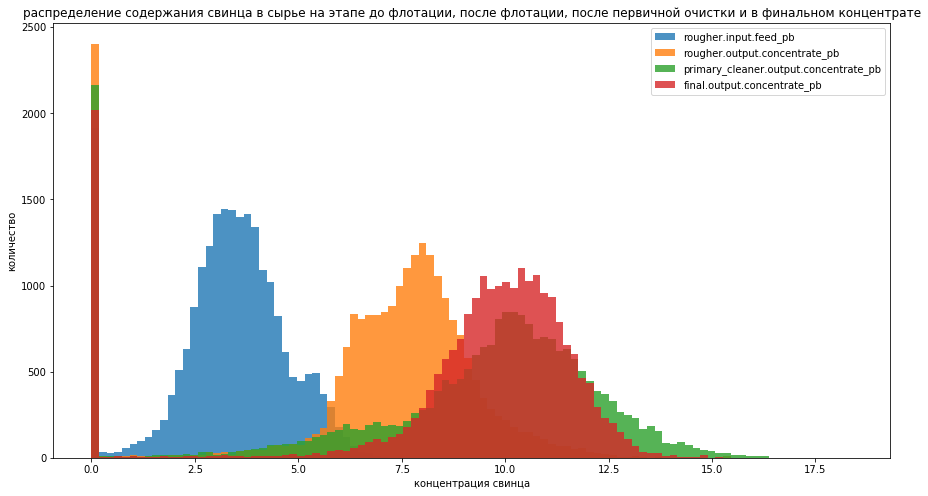

In [52]:
plumbum.plot(kind='hist', bins=100, alpha=0.8, figsize=(15,8))
plt.title("распределение содержания свинца в сырье на этапе до флотации, после флотации, после первичной очистки и в финальном концентрате"); 
plt.xlabel("концентрация свинца")
plt.ylabel("количество")
plt.show()

Видим, что в финальном концентрате свинец более чист и в большем объме высокие концентрации свинца, распределение Уже, что хорошо.

                Содержание свинца в отвальных хвостах после флотации, после первичной обработки и после вторичной обработки

In [53]:
plumbum_tail = work_full[['rougher.output.tail_pb','primary_cleaner.output.tail_pb','secondary_cleaner.output.tail_pb', 'final.output.tail_pb']]

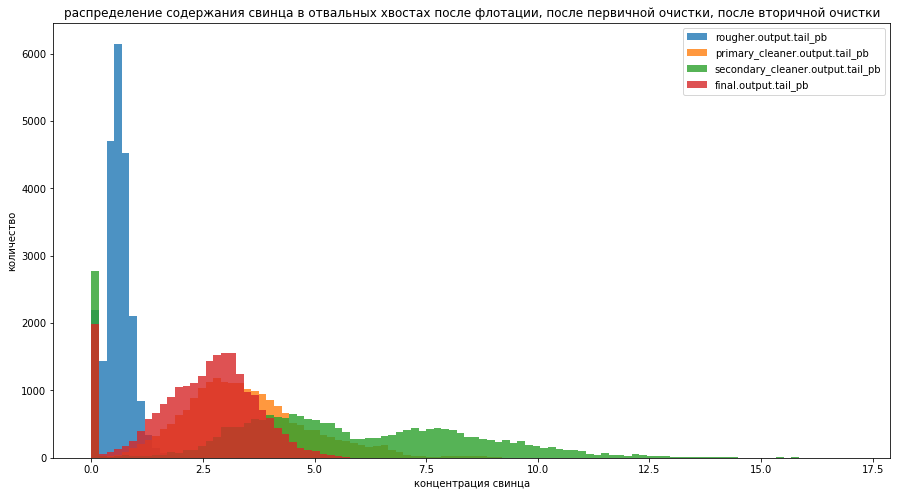

In [54]:
plumbum_tail.plot(kind='hist', bins=100, alpha=0.8, figsize=(15,8))
plt.title("распределение содержания свинца в отвальных хвостах после флотации, после первичной очистки, после вторичной очистки"); 
plt.xlabel("концентрация свинца")
plt.ylabel("количество")
plt.show()

Максмальная потеря свинца происходит на вторичной очистке, причем распределение двухгорбое и значительно широкое, отличающееся от всех остальных распределений. С чем это связано? Возможно с химико-физическими свойствами, погрешностями в технологии, качеством сырья и очистных материалов, хотя последнее - врядли, т.к. это отразилось только на свинце, скорее - особенности физико-химической природы самого свинца.  

                                                ***

__2.2.__ 

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

In [55]:
work_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5856 non-null   float64       
 2   primary_cleaner.input.depressant            5856 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5856 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5856 non

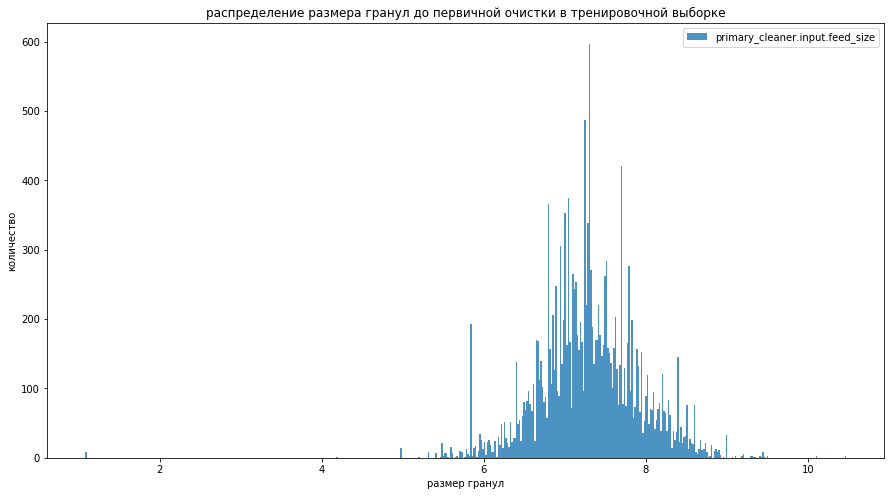

In [56]:
feed_size_train = work_train[['primary_cleaner.input.feed_size']] 
feed_size_train.plot(kind='hist', bins=500, alpha=0.8, figsize=(15,8))
plt.title("распределение размера гранул до первичной очистки в тренировочной выборке"); 
plt.xlabel("размер гранул")
plt.ylabel("количество")
plt.show()

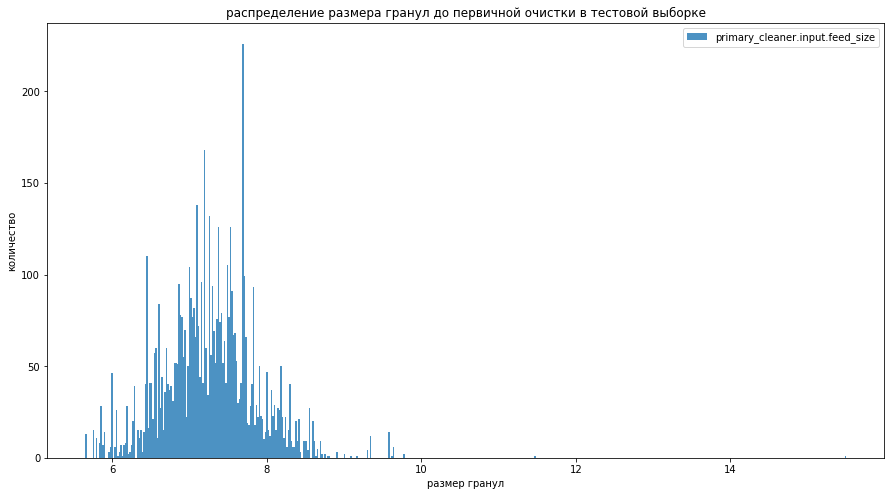

In [57]:
feed_size_test = work_test[['primary_cleaner.input.feed_size']] 
feed_size_test.plot(kind='hist', bins=500, alpha=0.8, figsize=(15,8))
plt.title("распределение размера гранул до первичной очистки в тестовой выборке"); 
plt.xlabel("размер гранул")
plt.ylabel("количество")
plt.show()

In [58]:
display(feed_size_train.describe())
display(feed_size_test.describe())

,primary_cleaner.input.feed_size
count,16860.000000
mean,7.297285
std,0.619166
min,1.080000
25%,6.940000
50%,7.285000
75%,7.700000
max,10.470000


,primary_cleaner.input.feed_size
count,5856.000000
mean,7.264651
std,0.611526
min,5.650000
25%,6.885625
50%,7.259333
75%,7.650000
max,15.500000


Размер гранул перед первичной очисткой - примерно идентичный. Что отлично, значит проблем при прогнозе на данном этапе не будет.

Посмотрим на размер гранул перед флотацией.

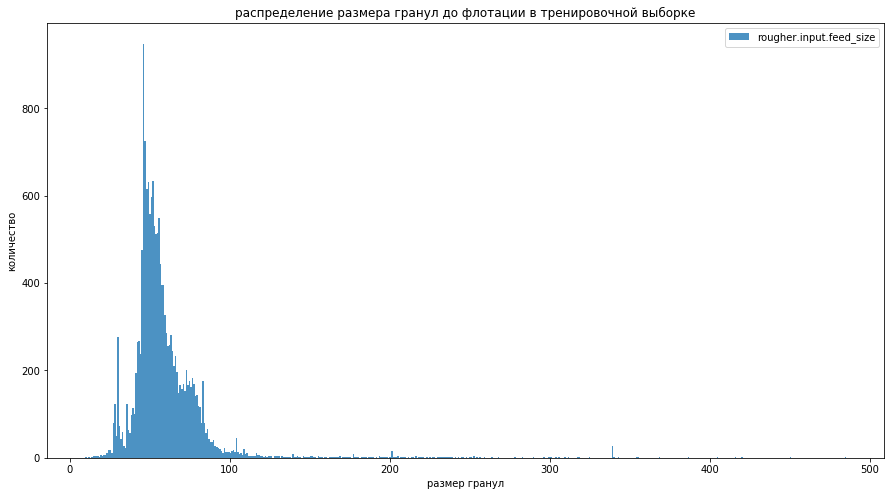

In [59]:
feed_size_train = work_train[['rougher.input.feed_size']] 
feed_size_train.plot(kind='hist', bins=500, alpha=0.8, figsize=(15,8))
plt.title("распределение размера гранул до флотации в тренировочной выборке"); 
plt.xlabel("размер гранул")
plt.ylabel("количество")
plt.show()

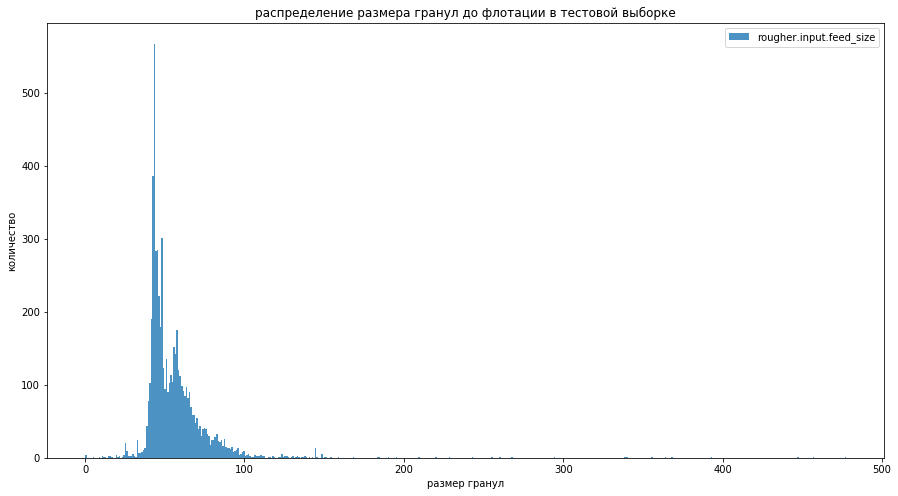

In [60]:
feed_size_test = work_test[['rougher.input.feed_size']] 
feed_size_test.plot(kind='hist', bins=500, alpha=0.8, figsize=(15,8))
plt.title("распределение размера гранул до флотации в тестовой выборке"); 
plt.xlabel("размер гранул")
plt.ylabel("количество")
plt.show()

In [61]:
display(feed_size_train.describe())
display(feed_size_test.describe())

,rougher.input.feed_size
count,16860.000000
mean,59.152776
std,26.131277
min,9.659576
25%,47.540138
50%,54.029671
75%,65.272775
max,484.967466


,rougher.input.feed_size
count,5856.000000
mean,55.886800
std,22.704970
min,0.046369
25%,43.865121
50%,49.964796
75%,61.615634
max,477.445473


Размер частиц до флотации также примерно равен. Значит дисбаланса нет.

                                        ***

__2.3.1__

Итак, исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Для этого - сперва просуммируем концентрацию всех веществ на разных стадиях для тренировочной, и на стадии до флотации для тестовой, т.к. в ней только этот признак.

In [62]:
work_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16860 non-null  float64       
 2   final.output.concentrate_pb                         16860 non-null  float64       
 3   final.output.concentrate_sol                        16860 non-null  float64       
 4   final.output.concentrate_au                         16860 non-null  float64       
 5   final.output.recovery                               16860 non-null  float64       
 6   final.output.tail_ag                                16860 non-null  float64       
 7   final.output.tail_pb                                16860 n

        Посмотрим на рабочей выборке и удалим найденные аномалии из нее.

In [63]:
work_train['sum_rougher_input_train'] = work_train['rougher.input.feed_au'] + work_train['rougher.input.feed_ag'] + work_train['rougher.input.feed_pb'] + work_train['rougher.input.feed_sol']


In [64]:
work_train['sum_rougher_output_train'] = work_train['rougher.output.concentrate_au'] + work_train['rougher.output.concentrate_ag'] + work_train['rougher.output.concentrate_pb'] + work_train['rougher.output.concentrate_sol']


In [65]:
work_train['sum_primary_train'] = work_train['primary_cleaner.output.concentrate_au'] + work_train['primary_cleaner.output.concentrate_ag'] + work_train['primary_cleaner.output.concentrate_pb'] + work_train['primary_cleaner.output.concentrate_sol']


In [66]:
work_train['sum_final_train'] = work_train['final.output.concentrate_au'] + work_train['final.output.concentrate_ag'] + work_train['final.output.concentrate_pb'] + work_train['final.output.concentrate_sol']


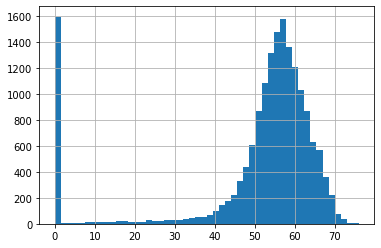

In [67]:
work_train['sum_rougher_input_train'].hist(bins=50)

            Предлогаю так - посмотрели, оценили и удалили сразу,т.к. несколько этапов, чтоб не возвращаться и не вспоминать.
            Возможно потом меньше придется удалять или вовсе не придется, это было бы логично предположить, 
            что нули на входе дадут в последующем нули.


In [68]:
work_train['sum_rougher_input_train'].describe()

count    16860.000000
mean        50.437052
std         18.150602
min          0.000000
25%         50.255223
50%         55.772467
75%         60.258431
max         76.024095
Name: sum_rougher_input_train, dtype: float64

In [69]:
len(work_train[work_train['sum_rougher_input_train'] < 10])*100/len(work_train)

9.715302491103202

Удаляя значения, которые дают в сумме значения меньше 10 - удаляем 9,7% данных.

Всё ради чистоты, но получаем ли мы чистоту или удаляем совершенно реальные данные?

In [70]:
work_train = work_train[work_train['sum_rougher_input_train'] >= 10]

Проверим, как изменилось распределение.

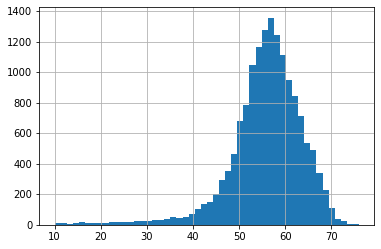

In [71]:
work_train['sum_rougher_input_train'].hist(bins=50)

In [72]:
work_train['sum_rougher_input_train'].describe()

count    15222.000000
mean        55.845854
std          7.977054
min         10.011538
25%         52.376780
50%         56.579350
75%         60.810579
max         76.024095
Name: sum_rougher_input_train, dtype: float64

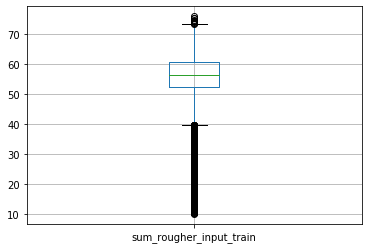

In [73]:
pd.DataFrame(work_train['sum_rougher_input_train']).boxplot()

boxplot() - не лучший метод для визуализации аномалий.

Но по гистограмме видно, что имеется длинный хвост влево, и думаю, что то, что левее 10, можно счесть за аномалию, к тому же это около 10%. Можно удалить! Удалять будем в work_train чуть ниже, на которой будем и учить модель, там имеются эти признаки.


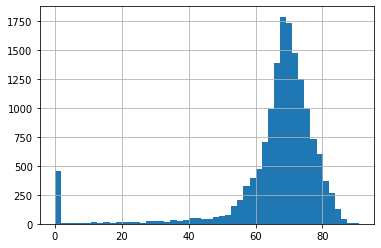

In [74]:
work_train['sum_rougher_output_train'].hist(bins=50)

In [75]:
work_train['sum_rougher_output_train'].describe()

count    15222.000000
mean        66.180189
std         15.089140
min          0.000000
25%         64.463968
50%         69.130345
75%         73.582922
max         90.964431
Name: sum_rougher_output_train, dtype: float64

In [76]:
len(work_train[work_train['sum_rougher_output_train'] < 40]) * 100 / len(work_train)

5.143870713441072

In [77]:
len(work_train[work_train['sum_rougher_output_train'] < 20]) * 100 / len(work_train)

3.6066219944816713

примерно на значении 52 - резкое снижение. Но процент все равно остается ощутимым, поэтому менее 20.

In [78]:
work_train = work_train[work_train['sum_rougher_output_train'] >= 20]

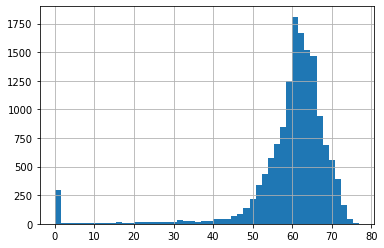

In [79]:
work_train['sum_primary_train'].hist(bins=50)

In [80]:
len(work_train[work_train['sum_primary_train'] < 10]) * 100 / len(work_train)

2.208137395215702

Удалим ещё 2 процента

In [81]:
work_train = work_train[work_train['sum_primary_train'] >= 10]

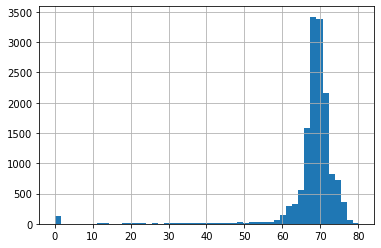

In [82]:
work_train['sum_final_train'].hist(bins=50)

In [83]:
len(work_train[work_train['sum_final_train'] < 40]) * 100 / len(work_train)

1.7492508188723952

И ещё 1,7%

In [84]:
work_train = work_train[work_train['sum_final_train'] >= 40]

In [85]:
100 - (len(work_train)*100/len(df_train)) 

16.381969157769873

Улил 16% данных из тренировочной выборки.

И избавился таким образом от нулей и очень длинных хвостов.
Как это отразится на работе модели? Увидим.

In [86]:
work_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5856 non-null   float64       
 2   primary_cleaner.input.depressant            5856 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5856 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5856 non

In [87]:
work_test['sum_rougher_input'] = work_test['rougher.input.feed_au'] + work_test['rougher.input.feed_ag'] + work_test['rougher.input.feed_pb'] + work_test['rougher.input.feed_sol']

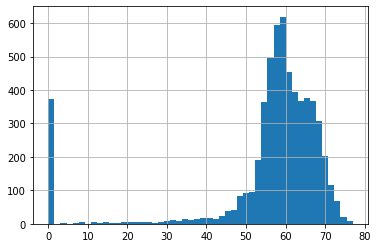

In [88]:
work_test['sum_rougher_input'].hist(bins=50)

In [89]:
len(work_test[work_test['sum_rougher_input'] < 30]) * 100 / len(work_test)

7.342896174863388

Думаю, что не критично удалить 7%. верно??

In [90]:
work_test = work_test[work_test['sum_rougher_input'] >= 30]

Итак, узнав, что нулевые и околонулевые значения подлежат удалению, т.к. с большой ероятностью это ошибка регистрирующей концентрацию аппаратуры и датчиков, мы удалили эти значения в тренировочной и тестовой выборки.

# 3. Модель

Выходим на финишную прямую.

Надеюсь, что это не мираж.

__3.1.__

Напишием функцию для вычисления итоговой sMAPE (final_smape).


In [91]:
def final_smape(target, prediction):
    general_smape = np.sum(abs(target - prediction)/ ((abs(target) + abs(prediction)) / 2)) * 100 / len(target)
    
    finish = ((0.25 * general_smape['rougher.output.recovery']) + (0.75 * general_smape['final.output.recovery'])).mean()
    return(finish)

__3.2.__

Далее подготовим features and target для модели.

In [92]:
work_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14098 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 92 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14098 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14098 non-null  float64       
 2   final.output.concentrate_pb                         14098 non-null  float64       
 3   final.output.concentrate_sol                        14098 non-null  float64       
 4   final.output.concentrate_au                         14098 non-null  float64       
 5   final.output.recovery                               14098 non-null  float64       
 6   final.output.tail_ag                                14098 non-null  float64       
 7   final.output.tail_pb                                14098 n

In [93]:
train_target = work_train[['rougher.output.recovery', 'final.output.recovery']]

Только теперь можем удалять признаки из work_train, которых нет в тестовой выборке.

In [94]:
train_features = work_train

In [95]:
for name in features_to_del:
    train_features = train_features.drop(name, axis=1)

In [96]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14098 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 57 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        14098 non-null  datetime64[ns]
 1   primary_cleaner.input.sulfate               14098 non-null  float64       
 2   primary_cleaner.input.depressant            14098 non-null  float64       
 3   primary_cleaner.input.feed_size             14098 non-null  float64       
 4   primary_cleaner.input.xanthate              14098 non-null  float64       
 5   primary_cleaner.state.floatbank8_a_air      14098 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_level    14098 non-null  float64       
 7   primary_cleaner.state.floatbank8_b_air      14098 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_level    14098 n

In [97]:
del train_features['sum_rougher_input_train']
del train_features['sum_rougher_output_train']
del train_features['sum_primary_train']
del train_features['sum_final_train']
del train_features['date']

train_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14098 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               14098 non-null  float64
 1   primary_cleaner.input.depressant            14098 non-null  float64
 2   primary_cleaner.input.feed_size             14098 non-null  float64
 3   primary_cleaner.input.xanthate              14098 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      14098 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    14098 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      14098 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    14098 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      14098 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    1409

            Далее готовим признаки и таргет для тестовой выборки.

In [98]:
work_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5426 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 56 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5426 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5426 non-null   float64       
 2   primary_cleaner.input.depressant            5426 non-null   float64       
 3   primary_cleaner.input.feed_size             5426 non-null   float64       
 4   primary_cleaner.input.xanthate              5426 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5426 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5426 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5426 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5426 non

In [99]:
test_target = work_test[['rougher.output.recovery', 'final.output.recovery']]

In [100]:
del work_test['rougher.output.recovery']
del work_test['final.output.recovery']

In [101]:
del work_test['sum_rougher_input']
del work_test['date']



In [102]:
test_features = work_test
test_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5426 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5426 non-null   float64
 1   primary_cleaner.input.depressant            5426 non-null   float64
 2   primary_cleaner.input.feed_size             5426 non-null   float64
 3   primary_cleaner.input.xanthate              5426 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5426 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5426 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5426 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5426 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5426 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5426 

In [103]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5426 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rougher.output.recovery  5426 non-null   float64
 1   final.output.recovery    5426 non-null   float64
dtypes: float64(2)
memory usage: 127.2 KB


In [104]:
test_target.head(2)

,rougher.output.recovery,final.output.recovery
date,,
2016-09-01 00:59:59,89.993421,70.273583
2016-09-01 01:59:59,88.089657,68.910432


Чтобы иметь представление насколько хорошо и адекватно работает наша модель, нам нужен ориентир, которым станет smape (заодно и проверим нашу функцию) "предпологаемой модели", которая выдает на все вопросы только средние значения.

Этим и займемся в следующем шаге - расчитаем нашу метрику для исключительно среднего значения.

__3.3.__

Получение sMAPE для среднего значения в качестве предсказания.

            для этого создадим серии с количеством элементов равным таргетным, 
            но заполненных исключительно средними значениями.

In [105]:
mean_target = test_target[['rougher.output.recovery','final.output.recovery']]
mean_target['rougher.output.recovery'] = test_target['rougher.output.recovery'].mean()
mean_target['final.output.recovery'] = test_target['final.output.recovery'].mean()

In [106]:
mean_smape = final_smape(test_target, mean_target)
mean_smape

9.947937870143884

Теперь нам есть с чем сравнивать работу своей модели.

Какие модели мы будем строить:

        1. Линейная регрессия
        2. Решающее дерево для регрессии
        3. Случайный лес для регрессии

__3.4.1__

Линейная регрессия

In [107]:
from sklearn.linear_model import LinearRegression

In [108]:
lin_model = LinearRegression()

metrics = make_scorer(final_smape)
result = cross_val_score(lin_model, train_features, train_target, cv=5, scoring=metrics)
result.mean()

10.253932864107744

Результат хуже, чем если бы она выдавала везде среднее значение. Явно ля компании не подходит такая модель.

__3.4.2.__

Реашющее дерево

In [109]:
from sklearn.tree import DecisionTreeRegressor

In [110]:
result_min = 100500
for depth in range(1, 21, 1):
    tree_model = DecisionTreeRegressor(max_depth = depth, random_state = 123)
    metrics = make_scorer(final_smape)
    result = (cross_val_score(tree_model, train_features, train_target, cv=5, scoring = metrics)).mean()
    
    if result < result_min:
        result_min = result
        depth_min = depth
    
print('model: DecisionTreeRegressor')
print('max_depth: ', depth_min)
print('min sMAPE {:.3f}'.format(result_min))

model: DecisionTreeRegressor
max_depth:  1
min sMAPE 9.561


Уже лучше, но незначительно. 

В арсенале есть ещё тяжеловесный Случайный Лес. Посмотрим на его результат.

__3.4.3__

Случайный лес

In [111]:
from sklearn.ensemble import RandomForestRegressor

        Постарался сократить интервал подбора параметров, чтобы сократить время ожидания, 
        эмпирически установив примерные интервалы в какой попадает минимальное значение sMAPE.

In [112]:
result_min = 100500

for estimator in range(4,11,2):
    for depth in range(8,15,2):
        for feature in range(5,10,2):
            for node in range(15,18,2):
                rf_model = RandomForestRegressor(n_estimators = estimator, max_depth = depth, max_features = feature, max_leaf_nodes = node, random_state=123)
                metrics = make_scorer(final_smape) 
                result = cross_val_score(rf_model, train_features, train_target, cv=5, scoring = metrics).mean()

                if result < result_min:
                    result_min = result
                    estimator_min = estimator 
                    depth_min = depth
                    feature_min = feature
                    node_min = node
                    optim_model = rf_model
                    
print('model: RandomForestRegressor')
print('n_estimator: ', estimator_min)
print('max_depth: ', depth_min)
print('max_feature: ', feature_min)
print('max_leaf_nodes: ', node_min)
print('min sMAPE {:.3f}'.format(result_min))                    
                    

model: RandomForestRegressor
n_estimator:  6
max_depth:  8
max_feature:  7
max_leaf_nodes:  17
min sMAPE 8.345


Лучший результат показал Случайный Лес, на 2 целых менее константной модели.

    model: RandomForestRegressor
    n_estimator:  6
    max_depth:  8
    max_feature:  7
    max_leaf_nodes:  17
    min sMAPE 8.345
    
Он выходит на работу с тестовой выборкой.

                                                   ***

__3.5.__

Апробация на тестовой выборке.

In [117]:
optim_model = RandomForestRegressor(n_estimators = estimator_min, max_depth = depth_min, max_features = feature_min, max_leaf_nodes = node_min, random_state=123)
print('заданные парамметры:')
print('n_estimator: ', estimator_min)
print('max_depth: ', depth_min)
print('max_feature: ', feature_min)
print('max_leaf_nodes: ', node_min)
print('min sMAPE при кроссвалидации на тренировочной выборке {:.3f}'.format(result_min))

заданные парамметры:
n_estimator:  6
max_depth:  8
max_feature:  7
max_leaf_nodes:  17
min sMAPE при кроссвалидации на тренировочной выборке 8.345


In [118]:
optim_model.fit(train_features, train_target)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features=7, max_leaf_nodes=17,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=6, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [119]:
prediction = optim_model.predict(test_features)

In [120]:
mega_final_smape = final_smape(test_target, prediction)
mega_final_smape

9.547884360093933

Увы, на тестовой выборке не смог показать результат схожий с результатом на тренировочной выборке. НО лучше, че константная модель.



Думаю, что самое тут время поразмышлять, а что ещё для дальнейшего улучшения качества можно предпринять?

Попробовать систематизировать:

1) качество данных на входе: ещё раз оценить аномалии, пропуски, соответствие физике (правдиво ли всё)

2) Работа с моделями:
- Генерация и поиск бизнес-факторов для моделирования: возможно что-то упустили, или придумать что-то гибридное из имеющихся факторов... В общем ещё раз пройтись по бизнес-цепочке процесса

- Подбор самих моделей. показателей самих моделей 

- Подбор параметров выбранных показателей у выбранных моделей 
    
3) Плюс, есть же ещё параметры самого процесса: температура, скорость конвейера, сила удара .... Они тоже могут помочь

4) Разобраться ещё раз с физическими и производственными процессами. Возможно приниципиально иное решение можно создать. 
    

Что можно посоветовать компании, что стало известно при выполнении проекта.

Количества серебра в отвальных хвостах, особенно после первичной и вторичной очистки больше, чем до флотации, возможно имеет смысл собирать их отдельно для дальнейшей очистки серебра.
